HW6-1:Transfer learning on pretrained VGG 16 (see Lecture 17)

 step 1: build vgg 16 pretrained model

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn

# Step 1: 設定裝置 (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

# 載入 VGG16 預訓練模型並修改輸出層
vgg16 = models.vgg16(weights='IMAGENET1K_V1')  # 載入預訓練權重
vgg16.classifier[6] = nn.Linear(4096, 2)  # 修改輸出層，分類為 2 類別

# 將模型移至 GPU
vgg16 = vgg16.to(device)
print(vgg16)

Using device: cuda

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, p

step 2: modify the code to use medical-mask github for training (modify 2 class)

In [2]:
import torch
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision.models as models

# 確認 GPU 裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 載入 VGG16 模型並微調部分層
vgg16 = models.vgg16(weights='IMAGENET1K_V1')

# 解凍最後幾層卷積層，保留部分特徵學習能力
for param in vgg16.features[:-4].parameters():  # 凍結大部分卷積層
    param.requires_grad = False

# 修改輸出層並加入 Dropout
vgg16.classifier[5] = nn.Dropout(p=0.5)  # 防止過擬合
vgg16.classifier[6] = nn.Linear(4096, 2)  # 修改輸出層為 2 類別
vgg16 = vgg16.to(device)

# 損失函數和優化器
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.2]).to(device))  # 假設類別不平衡
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001, weight_decay=1e-4)

# 資料增強設定
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # 隨機水平翻轉
    transforms.RandomRotation(15),      # 隨機旋轉
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 光線增強
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 載入訓練和驗證資料集
train_dataset = datasets.ImageFolder('./train', transform=train_transform)
val_dataset = datasets.ImageFolder('./test', transform=val_transform)
train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# 訓練模型
num_epochs = 10
for epoch in range(num_epochs):
    # 訓練階段
    vgg16.train()
    train_loss, train_correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    # 驗證階段
    vgg16.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()

    # 計算指標
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# 儲存模型
torch.save(vgg16.state_dict(), "vgg16_mask_classification_optimized.pth")
print("Model weights saved to 'vgg16_mask_classification_optimized.pth'")

Using device: cuda
Epoch [1/10] Train Loss: 0.0585, Train Acc: 0.9821 Val Loss: 0.0038, Val Acc: 1.0000
Epoch [2/10] Train Loss: 0.0319, Train Acc: 0.9933 Val Loss: 0.0497, Val Acc: 0.9865
Epoch [3/10] Train Loss: 0.0118, Train Acc: 0.9974 Val Loss: 0.0596, Val Acc: 0.9865
Epoch [4/10] Train Loss: 0.0199, Train Acc: 0.9944 Val Loss: 0.0015, Val Acc: 1.0000
Epoch [5/10] Train Loss: 0.0141, Train Acc: 0.9972 Val Loss: 0.0004, Val Acc: 1.0000
Epoch [6/10] Train Loss: 0.0055, Train Acc: 0.9990 Val Loss: 0.0837, Val Acc: 0.9865
Epoch [7/10] Train Loss: 0.0074, Train Acc: 0.9982 Val Loss: 0.0151, Val Acc: 0.9865
Epoch [8/10] Train Loss: 0.0058, Train Acc: 0.9987 Val Loss: 0.0532, Val Acc: 0.9865
Epoch [9/10] Train Loss: 0.0170, Train Acc: 0.9977 Val Loss: 0.0000, Val Acc: 1.0000
Epoch [10/10] Train Loss: 0.0108, Train Acc: 0.9972 Val Loss: 0.0002, Val Acc: 1.0000
Model weights saved to 'vgg16_mask_classification_optimized.pth'


step 3: allow program to input image http , then classify which class it is.

C:\Users\jing5\AppData\Local\Temp\ipykernel_19304\3540148110.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg16.load_state_dict(torch.load("vgg16_mask_classification

Prediction: with_mask


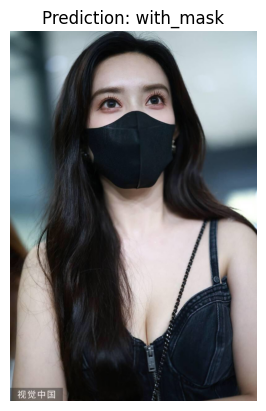

Prediction: without_mask


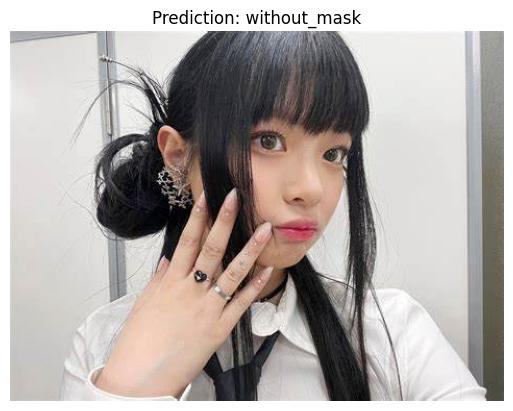

手動退出，程式結束！


In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt

# 重新定義模型架構並載入權重
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
vgg16.classifier[6] = nn.Linear(4096, 2)  # 修改輸出層
vgg16.load_state_dict(torch.load("vgg16_mask_classification_optimized.pth"))  # 載入權重
vgg16 = vgg16.to(device)
vgg16.eval()

# 圖片預測函數
def test_image(image_url, model, device):
    try:
        # 下載圖片
        response = requests.get(image_url, stream=True)
        img = Image.open(response.raw).convert('RGB')

        # 圖片預處理
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_tensor = preprocess(img).unsqueeze(0).to(device)

        # 預測
        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)

        # 輸出預測結果
        classes = ["with_mask", "without_mask"]
        prediction = classes[predicted.item()]
        print(f"Prediction: {prediction}")

        # 顯示圖片
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Prediction: {prediction}")
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# 連續輸入圖片網址，直到手動退出
while True:
    image_url = input("請輸入圖片網址（輸入 'exit' 退出）： ")
    if image_url.lower() == 'exit':
        print("手動退出，程式結束！")
        break
    test_image(image_url, vgg16, device)